<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Plot-modes-and-obs" data-toc-modified-id="Plot-modes-and-obs-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Plot modes and obs</a></span></li><li><span><a href="#Plot-performance-w.-time" data-toc-modified-id="Plot-performance-w.-time-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Plot performance w. time</a></span></li><li><span><a href="#Find-correlation-between-params" data-toc-modified-id="Find-correlation-between-params-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Find correlation between params</a></span></li></ul></div>

In [1]:
%cd ../..
%load_ext autoreload
%autoreload 2


C:\Users\julia\Documents\Imperial\DA_project


In [2]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import pipeline
import seaborn as sns
sns.set()
from matplotlib.ticker import ScalarFormatter
sns.set_style("whitegrid")
#sns.set_palette("Dark2")

In [3]:
B = os.getcwd() + "/experiments/"
modesfp = [B + "TSVD2/modes/", B +  "TSVD3/modes/"]
nobsfp = [B + "TSVD2/nobs/", B +  "TSVD3/nobs/"]


In [4]:
outfp1 = "report/figures/TSVD_nobs.png"
outfp2 = "report/figures/TSVD_modes.png"
outfp_time = "report/figures/comp_time.png"

In [5]:
def get_num(file, ):
    num = ""
    for idx, c in enumerate(file):
        if c.isnumeric():
            num += c
        else:
            break
    if num is "":
        
        assert file[:4] == "None", "file[:4] should be None but is = {}".format(file[:4])
        idx = 3
        num = None
    else:
        num = int(num)
        
    return num, idx

def get_tsvd_best_df(fps, prov_nobs, prov_modes):
    results = []
    for fp in fps:
        for path, subdir, files in os.walk(fp):
            for file_orig in files:
                file = file_orig
                if file[-4:] != ".csv":
                    continue
                file = file.replace("modes", "")
                
                modes, idx = get_num(file)

                file = file[idx:]

                if file[0] == "A":
                    file = file[3:]
                    nobs = "ALL"
                elif file[0] == "_":
                    file = file[1:]
                    nobs, idx = get_num(file)
                fp = os.path.join(path, file_orig)
                vals = []
                df = pd.read_csv(fp)

                if nobs == prov_nobs and modes == prov_modes:
                    return df
            
    return None    

def get_tsvd_data(fps, keys, drop_first=False):
    results = []
    for fp in fps:
        for path, subdir, files in os.walk(fp):
            for file_orig in files:
                file = file_orig
                if file[-4:] != ".csv":
                    continue
                file = file.replace("modes", "")
                 
                modes, idx = get_num(file)

                file = file[idx:]

                if file[0] == "A":
                    file = file[3:]
                    nobs = "ALL"
                elif file[0] == "_":
                    file = file[1:]
                    nobs, idx = get_num(file)
                fp = os.path.join(path, file_orig)
                vals = []
                for kidx, key_ in enumerate(keys):
                    df = pd.read_csv(fp)
                    if drop_first[kidx]:
                        df = df.drop(0)
                    val = df[key_].mean()
                    vals.append(val)
                vals = tuple(vals)
                results.append(vals + (nobs, modes))
    res = pd.DataFrame(results, columns=keys + [ "nobs", "modes"])
    return res      
keys = ["mse_DA", "time"]
drop = [0, 1]

nobsdf = get_tsvd_data(nobsfp, keys, drop)
modesdf = get_tsvd_data(modesfp, keys, drop)
modesdf
modesdf.to_csv( "report/data/modesdf.csv")
nobsdf.to_csv( "report/data/nobsdf.csv")

## Plot modes and obs


In [6]:
#modes2475["mse_DA"].mean()

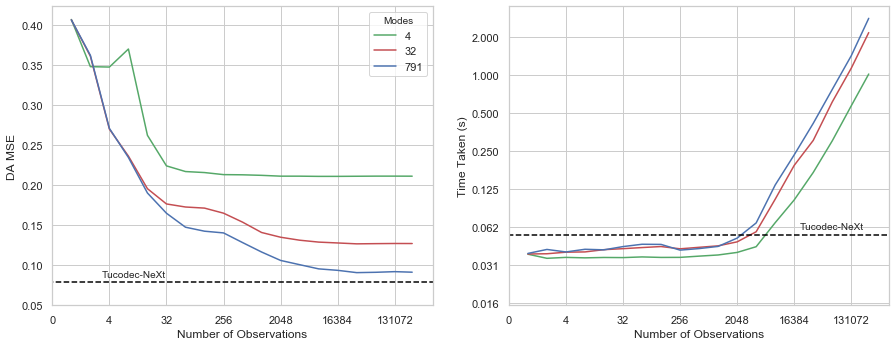

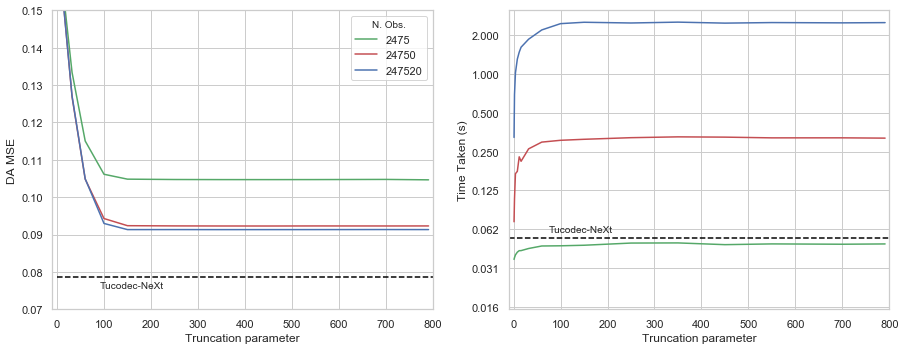

In [6]:

def plot_val(val, dfs, title, savefp, legend_labels=None, Tucodec_mse=0.078657345, Tucodec_time=0.05372):
    colours = ["g", "r", "b"]
    
    def sort_vals(df, val, yval):
        df = df.copy()
        x = df[val]
        y = df[yval]
        lists = sorted(zip(*[x, y]))
        new_x, new_y = list(zip(*lists))
        return new_x, new_y
    
    fig, axs = plt.subplots(1, 2,  sharey=False)
    
    if not isinstance(dfs, list):
        dfs = [dfs]
    assert len(colours) >= len(dfs)
    if len(dfs) > 1:
        assert legend_labels is not None
        assert len(dfs) == len(legend_labels)
    
    lines = []
    for idx, df in enumerate(dfs):
        x, y = sort_vals(df, val, "mse_DA")

        #plot left
        ax = axs[0]
        ax.plot(x, y, "-" + colours[idx])
        ax.set_xlabel(title)
        ax.set_ylabel("DA MSE")

        if val == "nobs":
            ax.set_xscale("log", basex=2)
            ax.xaxis.set_major_formatter(ScalarFormatter())
        
        ax = axs[1] 
        x, y = sort_vals(df, val, "time")
        l = ax.plot(x, y, "-" + colours[idx])
        lines.append(l[0])
        ax.set_xlabel(title)
        ax.set_ylabel("Time Taken (s)")
        fig.set_size_inches(15, 5.5)
        
        if val== "nobs":
            ax.set_xscale("log", basex=2)
            ax.set_yscale("log", basey = 2)
            ax.xaxis.set_major_formatter(ScalarFormatter())
            ax.yaxis.set_major_formatter(ScalarFormatter())
        else:
            ax.set_yscale("log", basey=2)
            ax.yaxis.set_major_formatter(ScalarFormatter())
    if len(dfs) > 1:
        ltitle = None
        if val == "nobs":
            ltitle = "Modes"
        elif val == "modes":
            ltitle = "N. Obs."
        axs[0].legend(lines, legend_labels, title=ltitle)
    
    
    #add dotted lines for tucodec values
    x = np.linspace(0.1,1e7,10)
    y = 0 * x + Tucodec_mse
    axs[0].plot(x, y, '--', color="black")
    
    x = np.linspace(-10,1e7,10)
    y = 0 * x + Tucodec_time
    
    axs[1].plot(x, y, '--', label="Tucodec", color="black")
    
    if val== "nobs":
        #xmax = 150000
        xmax = 91 * 85 * 32 #TODO - uncomment
        xmax = 2**19
        xmin = 0.5
        ymax0 = None
        ymin0 = 0.05
        ymax1 = None
        ymin1 = 0.015
    else:
        xmax = 800
        xmin = -10
        ymax0 = 0.15
        ymin0 = 0.07
        ymax1 = None
        ymin1 = 0.015
        
    axs[0].set_xlim(xmin, xmax)
    axs[1].set_xlim(xmin, xmax)
    
    axs[0].set_ylim(ymin0, ymax0)
    axs[1].set_ylim(ymin1, ymax1)

    #add floating tucodec label
    if val== "nobs":
        x_pos0 = 3
        y_pos0 = Tucodec_mse + 0.007
        x_pos1 = 20000
        y_pos1 = Tucodec_time + 0.007
        #x_pos1 = 150000 #UNCOMMENT
        
    else:
        x_pos0 = 90
        y_pos0 = Tucodec_mse - 0.003
        x_pos1 = 75
        y_pos1 = Tucodec_time + 0.006
    axs[0].text(x_pos0, y_pos0, 'Tucodec-NeXt',)
    axs[1].text(x_pos1, y_pos1, 'Tucodec-NeXt',)

    fig.savefig(savefp)
    
nobs32 = nobsdf[nobsdf["modes"] == 32]
nobs4 = nobsdf[nobsdf["modes"] == 4]
nobs791 = nobsdf[nobsdf["modes"] == 791]

legend_labs = ["4", "32", "791"]

plot_val("nobs", [nobs4, nobs32, nobs791], "Number of Observations", outfp1, legend_labs)

modesAll = modesdf[modesdf["nobs"] == 247520]
modes2475 = modesdf[modesdf["nobs"] == 2475]
modes24750 = modesdf[modesdf["nobs"] == 24750]

legend_labs = ["2475", "24750", "247520"]

plot_val("modes", [modes2475, modes24750, modesAll], "Truncation parameter", outfp2, legend_labs)

In [8]:
nobs4, nobs32, nobs731
nobs731

NameError: name 'nobs731' is not defined

## Plot performance w. time

In [11]:
modesdf

,mse_DA,time,nobs,modes
0,0.092959,2.455707,247520,100
1,0.106120,0.046562,2475,100
2,0.154368,1.475349,247520,12
3,0.156859,0.042674,2475,12
4,0.091312,2.516798,247520,150
5,0.104811,0.047019,2475,150
6,0.148477,1.612786,247520,16
7,0.151727,0.042726,2475,16
8,0.385903,0.322102,247520,1
9,0.385877,0.036527,2475,1


In [8]:
#get TSVD data
modes = 32
nobs = 247520
df_SVD = get_tsvd_best_df(modesfp, nobs, modes) # get all obs and truncation param = 32

fp_AE = "experiments/retrain/Tucodec_prelu_next/349_test.csv"

#SVD_vtu = modesfp + "modes{}_{}obsav_da_MAE.vtu".format(modes, nobs)
#AE_vtu = "experiments/DA/06a_vtu/_0/AEav_da_MAE.vtu"

#print("AE", AE_vtu)
#print("SVD", SVD_vtu)
df_AE = pd.read_csv(fp_AE)
df_AE.head()
df_AE["mse_DA"].mean()


#get times
df1 = df_SVD.copy()
df1.drop(0)
tsvd = df1["time"].mean()

df2 = df_AE.copy()
df2.drop(0)
tae = df2["time"].mean()

print("SVD time", tsvd)
print("SVD MSE", df_SVD["mse_DA"].mean())
print("AE time", tae)
print("AE MSE", df_AE["mse_DA"].mean())

SVD time 2.0220354862019496
SVD MSE 0.12709434940444914
AE time 0.13179543901821078
AE MSE 0.08289474048095277


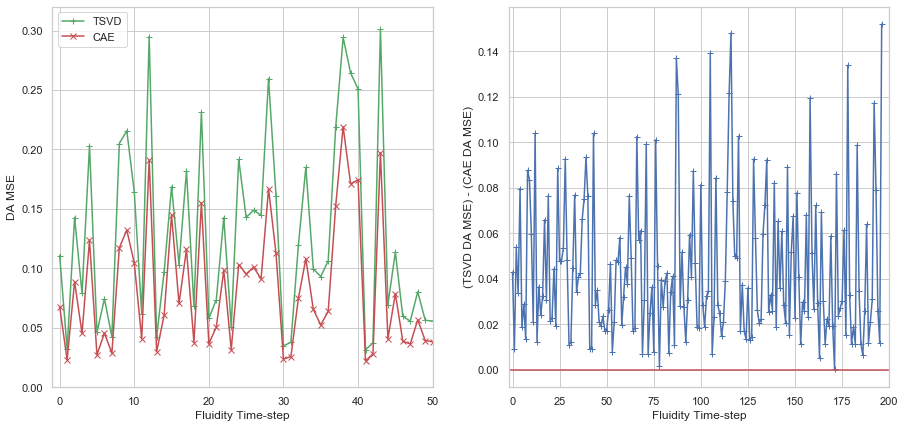

In [9]:
#Plot L2 on left axis and percent improvement on y axis against time
# Create some mock data
t = df_SVD.index


fig, axs = plt.subplots(1, 2,  sharey=False)


ax2 = axs[0]
ax2.set_ylabel('DA MSE', )  # we already handled the x-label with ax1
ax2.set_xlabel('Fluidity Time-step', )  

ax2.plot( t, 'mse_DA', data=df_SVD, marker='+', color="g", )
ax2.plot(t, 'mse_DA', data=df_AE, marker='x', color="r")
ax2.tick_params(axis='y',)


ax2.set_xlim(-1, 50)
ax2.set_ylim(0, 0.32)
ax2.legend(["TSVD", "CAE"] )

#plot difference
ax1 = axs[1]
ax1.set_ylabel('(TSVD DA MSE) - (CAE DA MSE)', )  # we already handled the x-label with ax1
ax1.set_xlabel('Fluidity Time-step', )  

y = df_SVD["mse_DA"] - df_AE["mse_DA"]
ax1.plot( t, y, marker='+', color="b", )
ax1.tick_params(axis='y',)

x = np.linspace(-6,300,10)
y = 0 * x
ax1.plot(x, y, '-r')
ax1.set_xlim(-2, 200)


fig.set_size_inches(15, 7)
plt.show()
fig.savefig(outfp_time)



SVD time 2.6870163890916077
SVD MSE 0.09131729271516509
AE time 0.13179543901821078
AE MSE 0.08289474048095277


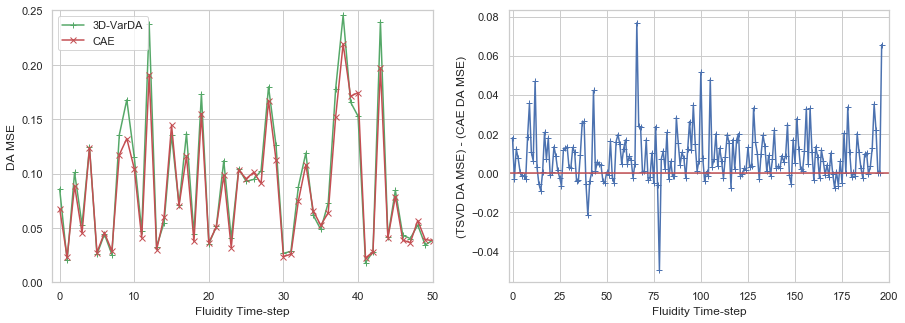

In [10]:
#Plot L2 on left axis and percent improvement on y axis against time
# Create some mock data
#get TSVD data
modes = 791
nobs = 247520
df_SVD = get_tsvd_best_df(modesfp, nobs, modes) # get all obs and truncation param = 32

# modes = 791
# nobs = 4096
# df_SVD = get_tsvd_best_df(nobsfp, nobs, modes) # get all obs and truncation param = 32



#print("AE", AE_vtu)
#print("SVD", SVD_vtu)
df_AE = pd.read_csv(fp_AE)
df_AE.head()
df_AE["mse_DA"].mean()


#get times
df1 = df_SVD.copy()
df1.drop(0)
tsvd = df1["time"].mean()

df2 = df_AE.copy()
df2.drop(0)
tae = df2["time"].mean()

print("SVD time", tsvd)
print("SVD MSE", df_SVD["mse_DA"].mean())
print("AE time", tae)
print("AE MSE", df_AE["mse_DA"].mean())


t = df_SVD.index


fig, axs = plt.subplots(1, 2,  sharey=False)


ax2 = axs[0]
ax2.set_ylabel('DA MSE', )  # we already handled the x-label with ax1
ax2.set_xlabel('Fluidity Time-step', )  

ax2.plot( t, 'mse_DA', data=df_SVD, marker='+', color="g", )
ax2.plot(t, 'mse_DA', data=df_AE, marker='x', color="r")
ax2.tick_params(axis='y',)


ax2.set_xlim(-1, 50)
ax2.set_ylim(0, 0.25)
ax2.legend(["3D-VarDA", "CAE"] )

#plot difference
ax1 = axs[1]
ax1.set_ylabel('(TSVD DA MSE) - (CAE DA MSE)', )  # we already handled the x-label with ax1
ax1.set_xlabel('Fluidity Time-step', )  

y = df_SVD["mse_DA"] - df_AE["mse_DA"]
ax1.plot( t, y, marker='+', color="b", )
ax1.tick_params(axis='y',)

x = np.linspace(-6,300,10)
y = 0 * x
ax1.plot(x, y, '-r')
ax1.set_xlim(-2, 200)


fig.set_size_inches(15, 5)
plt.show()
fig.savefig("report/figures/comp_time791.png")

In [19]:
modes = 791
nobs = 256
df_SVD = get_tsvd_best_df(nobsfp, nobs, modes) # get all obs and truncation param = 32

# modes = 791
# nobs = 4096
# df_SVD = get_tsvd_best_df(nobsfp, nobs, modes) # get all obs and truncation param = 32



#print("AE", AE_vtu)
#print("SVD", SVD_vtu)
df_AE = pd.read_csv(fp_AE)
df_AE.head()
df_AE["mse_DA"].mean()


#get times
df1 = df_SVD.copy()
df1  = df1.drop(0)
tsvd = df1["time"].mean()

df2 = df_AE.copy()
df2 = df2.drop(0)
tae = df2["time"].mean()

print("SVD time", tsvd)
print("SVD MSE", df_SVD["mse_DA"].mean())
print("AE time", tae)
print("AE MSE", df_AE["mse_DA"].mean())


SVD time 0.041099363443802814
SVD MSE 0.1403442258266337
AE time 0.10323015402774421
AE MSE 0.08289474048095277


## Find correlation between params

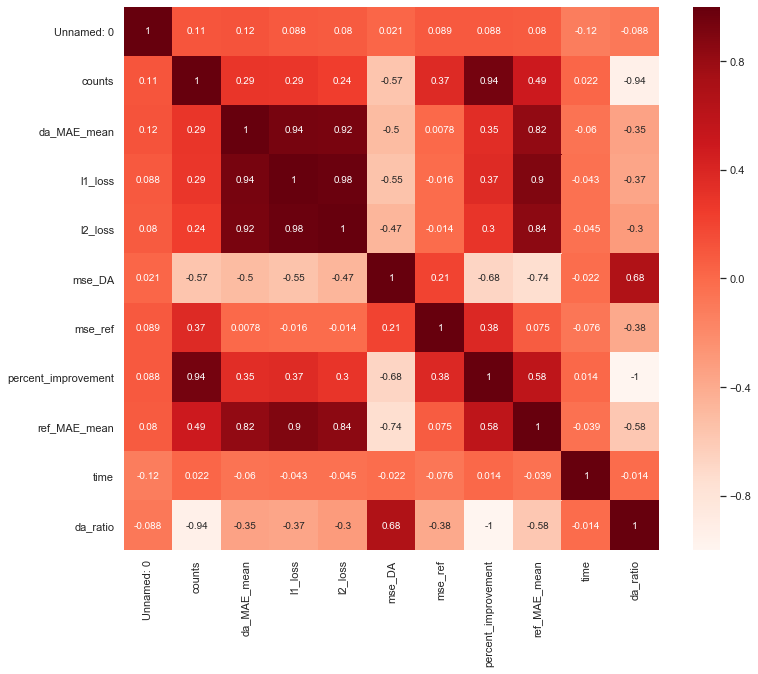

In [76]:
#copied from here: https://towardsdatascience.com/feature-selection-with-pandas-e3690ad8504b
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
#import statsmodels.api as sm
%matplotlib inline
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.feature_selection import RFE
from sklearn.linear_model import RidgeCV, LassoCV, Ridge, Lasso
#ADD column to df

df_AE["da_ratio"] = df_AE["da_MAE_mean"] / df_AE["ref_MAE_mean"] 

#Using Pearson Correlation
plt.figure(figsize=(12,10))
cor = df_AE.corr()
sns.heatmap(cor, annot=True, cmap=plt.cm.Reds)
plt.savefig("correlation_AE_data.png")
plt.show()
#plt.savefig("correlation_AE_data.png")

NOTE: there is NO correlation between percentage improvement and the reconstruction error. In fact the correlation coefficients are positive for this case (0.068 and 0.071) for L1 and L2 losses respectively when we would expect them to be negative (i.e. better reconstruction gives lower losses and higher percentage improvement).

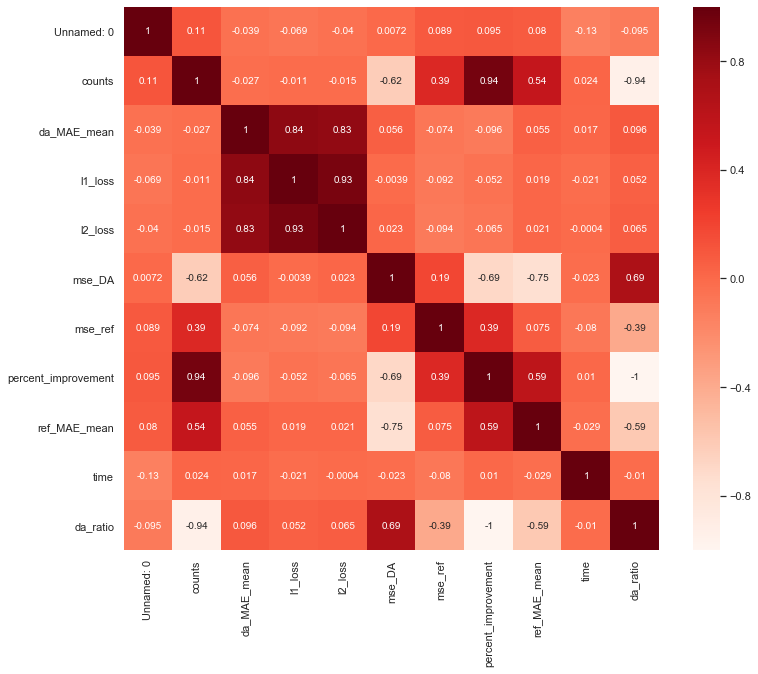

In [77]:
#Plot for SVD
df_SVD["da_ratio"] = df_SVD["da_MAE_mean"] / df_SVD["ref_MAE_mean"] 
plt.figure(figsize=(12,10))
cor = df_SVD.corr()
sns.heatmap(cor, annot=True, cmap=plt.cm.Reds)
plt.savefig("correlation_SVD_data.png")
plt.show()
